# Exercise 04 - Roof Classification in Aerial Images

In this notebook, we perform the task of classifying aerial images, each one showing exactly one building, according to the roof shapes (flat, hip, and other) they show. For this purpose, a fully connected network is build and trained, and afterwards a convolutional neural network (CNN). For the latter, also data augmentation is used. It is also shown how regularization techniques can improve network training.

**Learning objectives:**
- Repetition to perform the Deep Learning training process using a fully connected network with a new dataset
- Learn by an example how to interpret strange loss and quality metrics
- Use regularization techniques to improve network training
- Build your first convolutional neural network (CNN)
- Use data augmentation on the images of the training dataset

**Implement the relevant parts of this notebook on your own using the previous notebooks as templates.**

**Before you start, find a GPU on the system that is not heavily used by other users (with **nvidia-smi**), and change X to the id of this GPU.**

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 6
USE_GPU = 6

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-22 13:34:52.187523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 13:34:53.046404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:6 GPU


##  Dataset

The building roof dataset comprises of cutouts from a small number of aerial images, each showing one building roof that is labeled with one out of three categories: flat roof, hip roof and other (more complex) roof type. It is located in the shared folder of the Jupyter server at `~/coursematerial/GIS/dataset_img_building_roofs`. (You find the shared folder in your home (topmost) directory.) **You do not need to copy the data.** But if you need to, then there is a zip file in the parent directory (`~/coursematerial/GIS/dataset_img_building_roofs.zip`). Take a moment to explore the directory structure. There are three directories for the train, validation, and test split of the data. And in each of them, you find one directory for each category with the respective images.

In [3]:
from pathlib import Path
import os

data_dir = str(Path.home()) + r'/coursematerial/GIS/dataset_img_building_roofs/'

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

List the directories contained in the train, validation, and test directory.

In [4]:
print('train:     ', os.listdir(train_dir))
print('validation:', os.listdir(validation_dir))
print('test:      ', os.listdir(test_dir))

train:      ['flat_roof', 'other_roof', 'hip_roof']
validation: ['other_roof', 'hip_roof', 'flat_roof']
test:       ['hip_roof', 'other_roof', 'flat_roof']


Before we start, let us take a look at the number of images per class for the different splits, and also print the percentages of each class.

In [5]:
num_train_flat  = len(os.listdir(os.path.join(train_dir,'flat_roof')))
num_train_hip   = len(os.listdir(os.path.join(train_dir,'hip_roof')))
num_train_other = len(os.listdir(os.path.join(train_dir,'other_roof')))
num_train = num_train_flat + num_train_hip + num_train_other

num_valid_flat  = len(os.listdir(os.path.join(validation_dir,'flat_roof')))
num_valid_hip   = len(os.listdir(os.path.join(validation_dir,'hip_roof')))
num_valid_other = len(os.listdir(os.path.join(validation_dir,'other_roof')))
num_valid = num_valid_flat + num_valid_hip + num_valid_other

num_test_flat  = len(os.listdir(os.path.join(test_dir,'flat_roof')))
num_test_hip   = len(os.listdir(os.path.join(test_dir,'hip_roof')))
num_test_other = len(os.listdir(os.path.join(test_dir,'other_roof')))
num_test = num_test_flat + num_test_hip + num_test_other

print(f'Training data ({num_train}):')
print('  #images flat: ', f'{num_train_flat:>3} ({num_train_flat / num_train:.4f})')
print('  #images hip:  ', f'{num_train_hip:>3} ({num_train_hip / num_train:.4f})')
print('  #images other:', f'{num_train_other:>3} ({num_train_other / num_train:.4f})')

print()

print(f'Validation data ({num_valid}):')
print('  #images flat: ', f'{num_valid_flat:>3} ({num_valid_flat / num_valid:.4f})')
print('  #images hip:  ', f'{num_valid_hip:>3} ({num_valid_hip / num_valid:.4f})')
print('  #images other:', f'{num_valid_other:>3} ({num_valid_other / num_valid:.4f})')

print()

print(f'Testing data ({num_test}):')
print('  #images flat: ', f'{num_test_flat:>3} ({num_test_flat / num_test:.4f})')
print('  #images hip:  ', f'{num_test_hip:>3} ({num_test_hip / num_test:.4f})')
print('  #images other:', f'{num_test_other:>3} ({num_test_other / num_test:.4f})')

Training data (294):
  #images flat:  108 (0.3673)
  #images hip:   158 (0.5374)
  #images other:  28 (0.0952)

Validation data (72):
  #images flat:   27 (0.3750)
  #images hip:    39 (0.5417)
  #images other:   6 (0.0833)

Testing data (123):
  #images flat:   45 (0.3659)
  #images hip:    66 (0.5366)
  #images other:  12 (0.0976)


Keep these numbers in mind as they become important later.

And we also plot some example images. We plot four images of each class of the training data per row. First row are flat roofs, second row are hip roofs, and third row are other roofs.

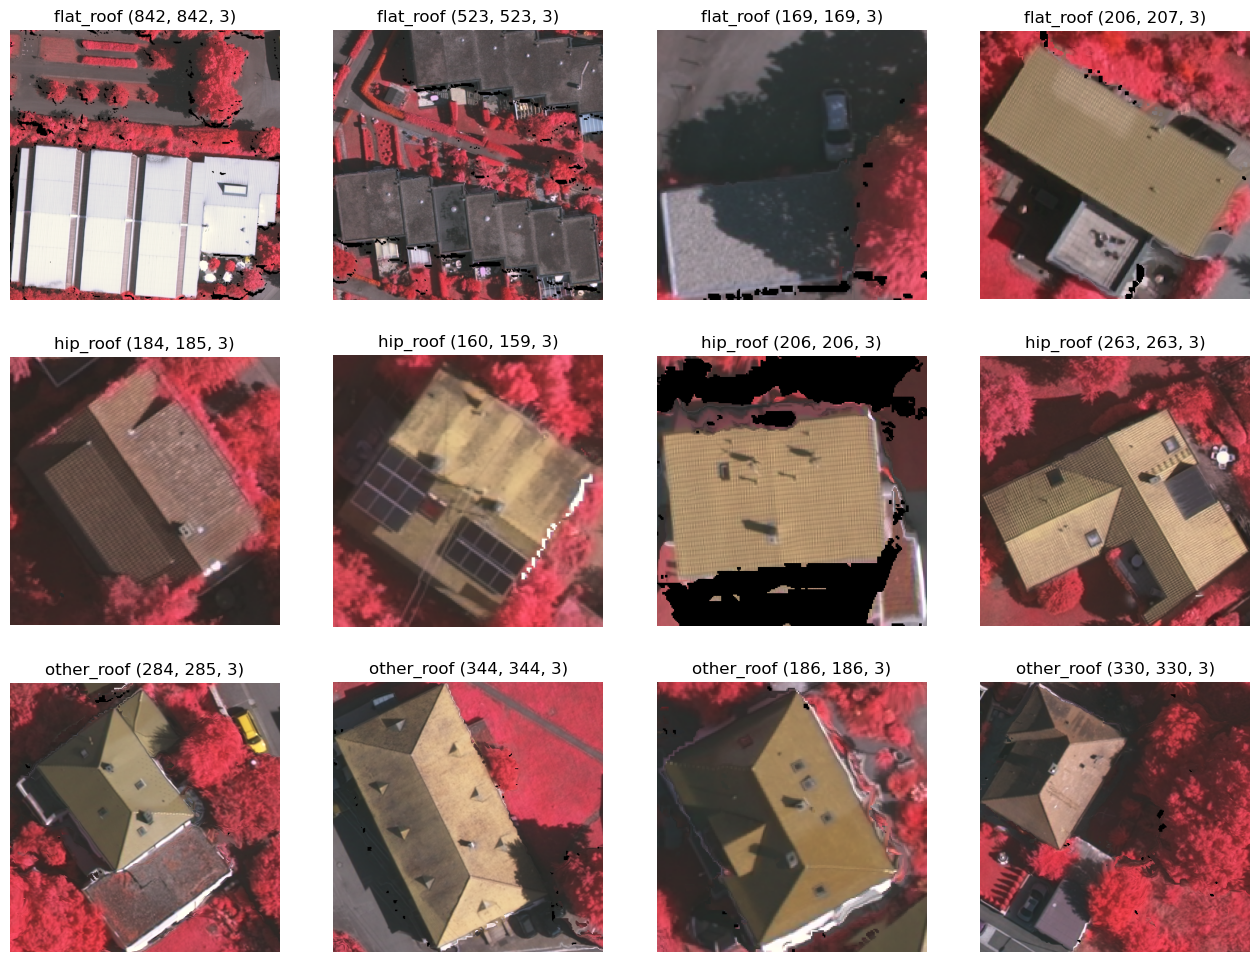

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools


roof_types = ['flat_roof', 'hip_roof', 'other_roof']
n_rows = len(roof_types)
n_cols = 4


# List all file names in each path, sample as many images as there are columns in the plot,
# and join them with their path to get complete path names (as otherwise we cannot load them
# with just the file name without the path).

img_names = []
for roof_type in roof_types:
    img_names.append([os.path.join(train_dir, roof_type, fname) for fname in 
        random.sample(os.listdir(os.path.join(train_dir,roof_type)), n_cols)])

fig = plt.gcf()
fig.set_size_inches(n_cols * 4, n_rows * 4)

for r,c in itertools.product(range(n_rows), range(n_cols)):
    index = n_cols * r + c
    plt.subplot(n_rows, n_cols, index + 1)
    img = mpimg.imread(img_names[r][c])
    plt.axis('off')
    plt.title(roof_types[r] + " " + str(img.shape))
    plt.imshow(img)

plt.show()

You might notice that the second row shows saddleback roofs and not hip roofs. It seems that the naming of the roof types is wrong. In the bottom row, there are hip roofs shown, but there are also other roof types that are more complex than just hip roofs. So, the class name 'other' might fit. The wrong naming does, however, not change the task to differentiate between three types of building roofs.

## Data generators

With this kind of data organization in separate folders, we can again use the `ImageDataGenerator` class. We need one generator for training, one for validation, and one for testing. Since the original set of images is already split into these three folds, there is no need to further split them.

In the following cell, some constants about the expected input image size and batches are defined. Please use them instead of providing the numbers directly.

In [7]:
BATCH_SIZE = 32

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

**Construct `ImageDataGenerator` objects for the training, validation, and test split of the data.**

Do not forget to rescale the input values (that originally range from 0 to 255) to the range from 0.0 to 1.0 by specifying with the `rescale` parameter of the constructor to multiply all values with `1.0/255.0`.

After constructing an image data generators, call it's `flow_from_directory`() method, e.g., with the training directory (`train_dir`), the target size (`target_size`) of the images as a tuple of width and height (using above constants), the batch size (`batch_size`) (also using above constants), and the class mode (`class_mode`) as `'categorical'`. (Remember what it means to use `'categorical'` and not `'sparse'` when defining your neural network and the training process!)

Your generators will yield batches of images (of the speficied size) and their categorical labels. One feature of the image generator is that we can point it at a parent directory (in our example called `train_dir`, `validation_dir`, and `test_dir`, respectively) and the generator will automatically generate labels from the sub-directories.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255.0,rotation_range=10,zoom_range=0.2)

print("\nData generator for training data:")

train_generator =  train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size =BATCH_SIZE,
        class_mode ='categorical',
        shuffle=True,
        seed=42)  # Seed for shuffling and transformations

validation_datagen = ImageDataGenerator(rescale=1.0/255.0) 
print("\nData generator for validation data:")



validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False) 

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
print("\nData generator for test data:")


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        shuffle = False)


Data generator for training data:
Found 294 images belonging to 3 classes.

Data generator for validation data:
Found 72 images belonging to 3 classes.

Data generator for test data:
Found 123 images belonging to 3 classes.


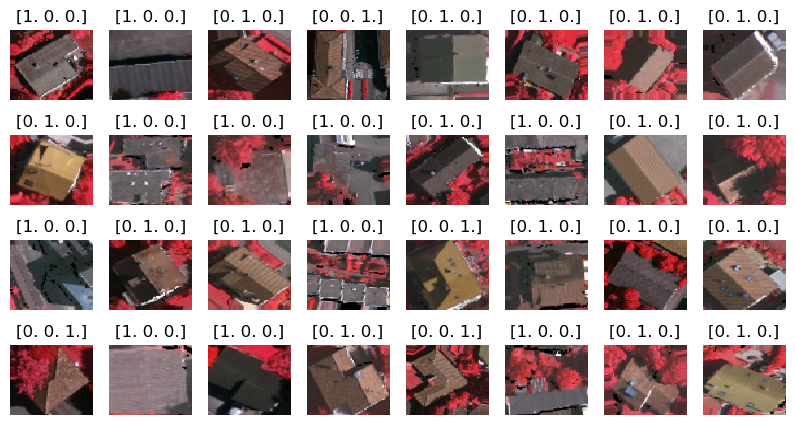

In [9]:

import itertools

data_batch, labels_batch = train_generator.next()

n_rows = 4
n_cols = 8

plt.figure(figsize = (10,5))

for r,c in itertools.product(range(n_rows), range(n_cols)):
    index = n_cols * r + c
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow((data_batch[index]-data_batch[index].min())/(data_batch[index].max()-data_batch[index].min()), interpolation="nearest", aspect='auto')
    plt.axis('off')
    plt.title(str(labels_batch[index]), fontsize=12) 
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Build and train a fully connected network

Construct a fully connected (sequential) neural network, e.g. with 3 layers of 64, 128, and 256 neurons (units) using a ReLU activation function, and a last layer with a softmax activation. (Although the images above look strange from the colors, they have 3 input channels.). We have 3 different classes.

In [10]:
from tensorflow.keras import models
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization


model_1 = models.Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    Dense(350, activation='relu'),
    Dense(150, activation='relu'),
    Dense(40, activation='relu'),
    Dense(3, activation='softmax')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 350)               4301150   
                                                                 
 dense_1 (Dense)             (None, 150)               52650     
                                                                 
 dense_2 (Dense)             (None, 40)                6040      
                                                                 
 dense_3 (Dense)             (None, 3)                 123       
                                                                 
Total params: 4,359,963
Trainable params: 4,359,963
Non-trainable params: 0
_________________________________________________________________


2023-11-22 13:34:57.245164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13416 MB memory:  -> device: 6, name: Quadro RTX 5000, pci bus id: 0000:c1:00.0, compute capability: 7.5


Define an early stopping callback that monitors the validation loss (`val_loss`), has a `patience` of 8 epochs, and restores the best weights by passing the Boolean value True to the `restore_best_weights` parameter.

In [11]:
# Define EarlyStopping callback.
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=8,   
    restore_best_weights=True  # Restores the  model weights from the epoch with the best value of the monitored quantity.
)


Compile the training process of the model. Use the Adam optimizer (`adam`), and `accuracy` as the performance metrics. Choose an appropriate loss function, but remember how the labels are provided by the data generators. (Possible choices are `categorical_crossentropy` or `sparse_categorical_crossentropy`. Which one is it?)

In [12]:
# Compile the model.
def learning_rate_schedule(epoch=150):
    initial_lr =  1.0947e-04
    decay_factor = 0.85
    decay_step = 10  # Adjust this based on your preferences
    lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return lr

# Define the learning rate schedule callback
lr_schedule_callback = LearningRateScheduler(learning_rate_schedule)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1.0947e-04)
#Nadam_optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001)
#sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.99, nesterov=True)
#adagrad_optimizer = tf.keras.optimizers.Adagrad(learning_rate= 1e-04) 
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model_1.compile(
    optimizer=adam_optimizer,  
    loss='categorical_crossentropy', # Do not forget for one-hot encoding its always categorical_crossentropy.
    metrics=['accuracy']             #For numerical labels use sparse categorical_crossentropy.
)


Train the model for 100 epochs, but use the early stopping callback to stop training when the loss of the validation data does not improve anymore. (Let the `fit()` method `shuffle` the training data, as otherwise the images are always shown in the same order.) 
We also plot the training and validation curves.

Epoch 1/100


2023-11-22 13:34:57.479912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-22 13:34:58.517089: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb6ac021570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 13:34:58.517146: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-22 13:34:58.521475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-22 13:34:58.645535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-11-22 13:34:58.751563: I .

10/10 [==============================] - ETA: 0s - loss: 0.9997 - accuracy: 0.4456

2023-11-22 13:35:00.671330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 164ms/step - loss: 0.9997 - accuracy: 0.4456 - val_loss: 0.9089 - val_accuracy: 0.6111 - lr: 1.0947e-04
Epoch 2/100
10/10 [==============================] - 1s 126ms/step - loss: 0.9196 - accuracy: 0.5748 - val_loss: 0.9081 - val_accuracy: 0.4722 - lr: 1.0947e-04
Epoch 3/100
10/10 [==============================] - 1s 120ms/step - loss: 0.8810 - accuracy: 0.5578 - val_loss: 0.8567 - val_accuracy: 0.6111 - lr: 1.0947e-04
Epoch 4/100
10/10 [==============================] - 1s 118ms/step - loss: 0.8045 - accuracy: 0.6531 - val_loss: 0.8090 - val_accuracy: 0.6111 - lr: 1.0947e-04
Epoch 5/100
10/10 [==============================] - 1s 118ms/step - loss: 0.7526 - accuracy: 0.6939 - val_loss: 0.7941 - val_accuracy: 0.6389 - lr: 1.0947e-04
Epoch 6/100
10/10 [==============================] - 1s 118ms/step - loss: 0.7620 - accuracy: 0.6633 - val_loss: 0.7740 - val_accuracy: 0.6667 - lr: 1.0947e-04
Epoch 7/100
10/10 [==============================] -

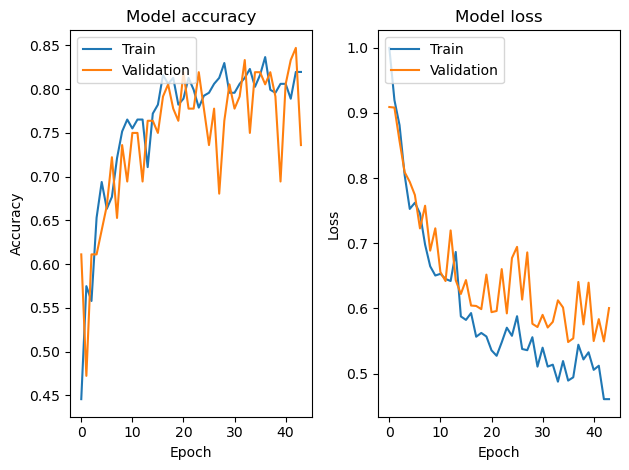

In [13]:
history = model_1.fit(
        train_generator,
        epochs=100,  # You can adjust the number of epochs based on your needs.
        shuffle=True,
        validation_data=validation_generator,
        callbacks=[early_stopping ,lr_schedule_callback], 
)


# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Evaluate the performance of your model on the test data.

In [14]:
test_metrics = model_1.evaluate(test_generator)
print("loss:",test_metrics[0], "accuracy:",test_metrics[1])

2023-11-22 13:35:52.620400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 110ms/step - loss: 0.7140 - accuracy: 0.7073
loss: 0.7140047550201416 accuracy: 0.707317054271698


Let us try to improve this model a little by using regularization. Import the dropout layer (with `from tensorflow.keras.layers import Dropout`), and add a `Dropout` layer after the second layer (with 128 neurons) and after the third layer (with 256 neurons), with a dropout rate of 0.5. (You can just pass this dropout value as the only parameter to the `Dropout` class constructor.)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a sequential model
model_2 = models.Sequential()

# Flatten the input assuming images with shape (height, width, channels)
model_2.add(layers.Flatten(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)))

# Add fully connected layers with ReLU activation and dropout
model_2.add(layers.Dense(350, activation='relu'))
model_2.add(layers.Dense(150, activation='relu'))
model_2.add(layers.Dropout(0.5)) 
model_2.add(layers.Dense(40, activation='relu'))
#model.add(layers.Dropout(0.5)) 
model_2.add(layers.Dense(3, activation='softmax'))

# Display the model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 350)               4301150   
                                                                 
 dense_5 (Dense)             (None, 150)               52650     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 40)                6040      
                                                                 
 dense_7 (Dense)             (None, 3)                 123       
                                                                 
Total params: 4,359,963
Trainable params: 4,359,963
No

Compile the training process and fit the model. (You can do this in the same cell to have a more compact notebook.)

In [16]:
# Compile the model

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1.0947e-04)

model_2.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model_2.fit(
    train_generator,
    batch_size=32,
    epochs=100,  
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/100


2023-11-22 13:35:53.500700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.4932

2023-11-22 13:35:55.981046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 122ms/step - loss: 1.0787 - accuracy: 0.4932 - val_loss: 0.9157 - val_accuracy: 0.5556
Epoch 2/100
10/10 [==============================] - 1s 120ms/step - loss: 1.0094 - accuracy: 0.5170 - val_loss: 0.8715 - val_accuracy: 0.5417
Epoch 3/100
10/10 [==============================] - 1s 126ms/step - loss: 1.0877 - accuracy: 0.5408 - val_loss: 0.9809 - val_accuracy: 0.6528
Epoch 4/100
10/10 [==============================] - 1s 114ms/step - loss: 0.9861 - accuracy: 0.5136 - val_loss: 0.8915 - val_accuracy: 0.5417
Epoch 5/100
10/10 [==============================] - 1s 115ms/step - loss: 0.9430 - accuracy: 0.5442 - val_loss: 0.8549 - val_accuracy: 0.6389
Epoch 6/100
10/10 [==============================] - 1s 116ms/step - loss: 0.9175 - accuracy: 0.5442 - val_loss: 0.8279 - val_accuracy: 0.7361
Epoch 7/100
10/10 [==============================] - 1s 116ms/step - loss: 0.8910 - accuracy: 0.5476 - val_loss: 0.7981 - val_accuracy: 0.6667
Epoch 8/100

The training process is not always the same. But the chance is high that the metric `val_accuracy` takes the value `0.5417` and does not change anymore. (You can try to fit the model a few more times if that is not the case. Just remember to build the model, compile it, and fit it. And not just call the fit() method, as you would otherwise continue to train the model.)

Now, evaluate the performance of the model.

In [17]:
model_2.evaluate(test_generator)

2023-11-22 13:36:29.642789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 96ms/step - loss: 0.7097 - accuracy: 0.6911


[0.7096642851829529, 0.6910569071769714]

If your training stopped with a validation accuracy of 0.5417, then your test accuracy probably is 0.5366. Have you maybe seen this values before? If not, then you probably got a well trained network. Congratulations. Try a few more times and see if your network gets stuck with 0.5417 validation accuracy. If not, then just assume that validation accuracy did not improve beyond `0.5417` and stayed at this level for the last epochs. Also assume that your test accuracy is ´0.5366´.

**Question 1: What happened during training and what is your neural network doing when performing predictions (both for validation and test data)?**

Ans : During training, a neural network undergoes an optimization process where it learns to map input data to the corresponding output labels. This process involves adjusting the weights and biases of the network's neurons to minimize the difference between predicted outputs and true labels, typically measured by a loss function. Training is performed on a labeled dataset, and the optimization algorithm (Adaptive Moment Estimation) updates the model parameters to reduce the prediction error.


**Question 2: Why is the loss improving (or changing) although the accuracy stays the same?**

In this case, the dropout rate prevents the training to converge properly. Adjusting some of the hyperparameters can help fix the problem (learning rate, or simply lowering the dropout rate a bit for example). Also, removing the EarlyStopping callback (or increasing the patience value). As the training loss is still improving, the model should start to learn at some point.

We could try and improve the neural network even further. But it is not worth it, since a fully connected network is not the best neural network model for image classification. Just take a look at the number of trainable weights, which is around 800,000.

## Build and train a convolutional neural network

In the next part, we use a convolutional neural network for the given task. In contrast to a fully connected network with dense layers, a convolutional neural network (CNN) takes the inputs not as a flat (1D) tensor, but works directly on 2D data (like images). We therefore do not need to flatten the data first.

A convolutional neural network is constructed in the same way as a fully connected network using the sequential model. We just use convolutional layers with convolutional filters and max pooling layers instead of dense layers. The TensorFlow convolutional layers for 2D data are called [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), and the max pooling layers [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Check the TensorFlow documentation for more details and descriptions of the class parameters.

Construct a convolutional neural network according to the following specifications:
- For feature extraction, **construct two 2D convolutional layers** (of class `Conv2D`) with max pooling (class `MaxPool2D`) after each convolutional layer. The number of filters (parameter `filters`) of the convolutional layers should be 32 and 64, and the filter size (parameter `kernel_size`) should be (3,3). Use ReLU as activation function. (By default, the `Conv2D` layers use a stride of (1,1), and no zero padding.) For max pooling, use a filter size (`pool_size`) of (2,2). 
- Next, insert a layer that flattens the 2D activation maps (3D activation volume) to a 1D tensor.
- For the classifier, use a dense layer with 128 units with ReLU activation function, and another dense layer that provides the right number of outputs as probabilities.

Do not forget to import the `Conv2D` and `MaxPool2D` classes from the module of keras layers (`tensorflow.keras.layers`).

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assuming input images with dimensions (height, width, channels)
height, width, channels = 64,64,3

# Define the model
model_3 = models.Sequential()

# Convolutional and pooling layers
model_3.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(height, width, channels)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before feeding into densely connected layers
model_3.add(layers.Flatten())

# Densely connected layers
model_3.add(layers.Dense(200, activation='relu'))
model_3.add(layers.Dense(150, activation='relu'))
model_3.add(layers.Dense(40, activation='relu'))

# Output layer with softmax activation for classification
model_3.add(layers.Dense(3, activation='softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 256)       

Compile the training process of the model in the same way as for the fully connected network. Fit the model for 100 epochs with early stopping.

In [19]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1.0947e-04)

model_3.compile(optimizer=adam_optimizer, loss= 'categorical_crossentropy',  metrics=['accuracy'])

history_2= model_3.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-22 13:36:30.455797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.5272

2023-11-22 13:36:34.327674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 130ms/step - loss: 1.0037 - accuracy: 0.5272 - val_loss: 0.9180 - val_accuracy: 0.5417
Epoch 2/100
10/10 [==============================] - 1s 115ms/step - loss: 0.9235 - accuracy: 0.5374 - val_loss: 0.9024 - val_accuracy: 0.5417
Epoch 3/100
10/10 [==============================] - 1s 118ms/step - loss: 0.9139 - accuracy: 0.5374 - val_loss: 0.8845 - val_accuracy: 0.5417
Epoch 4/100
10/10 [==============================] - 1s 119ms/step - loss: 0.9001 - accuracy: 0.5952 - val_loss: 0.8610 - val_accuracy: 0.5417
Epoch 5/100
10/10 [==============================] - 1s 117ms/step - loss: 0.8573 - accuracy: 0.5884 - val_loss: 0.8104 - val_accuracy: 0.7361
Epoch 6/100
10/10 [==============================] - 1s 116ms/step - loss: 0.8114 - accuracy: 0.6973 - val_loss: 0.7479 - val_accuracy: 0.8056
Epoch 7/100
10/10 [==============================] - 1s 117ms/step - loss: 0.7785 - accuracy: 0.6939 - val_loss: 0.7315 - val_accuracy: 0.7361
Epoch 8/100

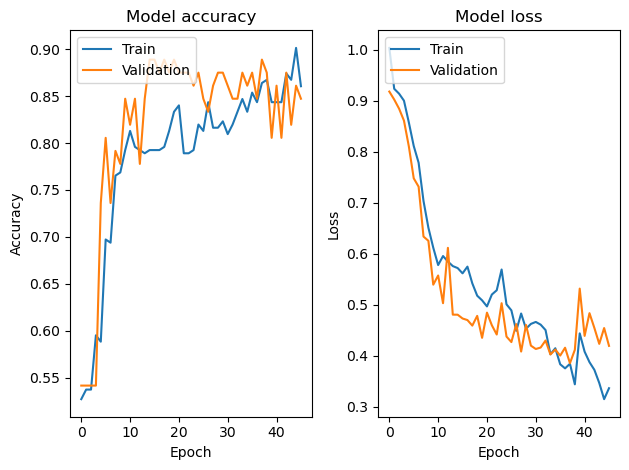

In [20]:
# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Evaluate the model. It should show a little improvement to the accuracy over the fully connected network above. (Or maybe not, depending on how successfuly your training of the fully connected networks were above.)

In [21]:
model_3.evaluate(test_generator)

2023-11-22 13:37:28.644555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 114ms/step - loss: 0.6059 - accuracy: 0.7724


[0.6059035658836365, 0.772357702255249]

If you take a look at the number of trainable parameters, you notice that there are now 1.6 million weights. That seems a lot, and is also much more than the fully connected network above.

**Question 3: Where are most of the parameters (weights) used in the fully connected network, and where are most of the parameters in the convolutional neural network? Why is this the case?**

Now it is your turn to improve the convolutional neural network for this task. Copy your network from above to the following cell, and make some improvements on your own to get a better accuracy. You could, e.g., add further layers, use more filters, add dropout regularization, or all together.

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assuming input images with dimensions (height, width, channels)
height, width, channels = 64,64,3

# Define the model
model_4 = models.Sequential()

# Convolutional and pooling layers
model_4.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(height, width, channels)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before feeding into densely connected layers
model_4.add(layers.Flatten())

# Densely connected layers
model_4.add(layers.Dense(150, activation='relu'))
model_4.add(layers.Dropout(0.5)) 
model_4.add(layers.Dense(40, activation='relu'))

# Output layer with softmax activation for classification
model_4.add(layers.Dense(3, activation='softmax'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 256)       

Compile the training process and fit the model.

In [23]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1.0947e-04)

model_4.compile(optimizer='adam', loss= 'categorical_crossentropy',  metrics=['accuracy'])

history = model_4.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100


2023-11-22 13:37:29.509776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 1.0272 - accuracy: 0.5000

2023-11-22 13:37:32.096876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 129ms/step - loss: 1.0272 - accuracy: 0.5000 - val_loss: 1.0038 - val_accuracy: 0.4583
Epoch 2/100
10/10 [==============================] - 1s 114ms/step - loss: 0.9811 - accuracy: 0.5306 - val_loss: 0.9226 - val_accuracy: 0.5417
Epoch 3/100
10/10 [==============================] - 1s 117ms/step - loss: 0.9584 - accuracy: 0.4864 - val_loss: 0.9696 - val_accuracy: 0.7083
Epoch 4/100
10/10 [==============================] - 1s 118ms/step - loss: 0.9412 - accuracy: 0.5238 - val_loss: 0.9126 - val_accuracy: 0.5417
Epoch 5/100
10/10 [==============================] - 1s 111ms/step - loss: 0.9334 - accuracy: 0.5306 - val_loss: 0.8957 - val_accuracy: 0.5417
Epoch 6/100
10/10 [==============================] - 1s 110ms/step - loss: 0.9461 - accuracy: 0.5306 - val_loss: 0.8660 - val_accuracy: 0.5694
Epoch 7/100
10/10 [==============================] - 1s 112ms/step - loss: 0.9223 - accuracy: 0.5340 - val_loss: 0.8691 - val_accuracy: 0.5417
Epoch 8/100

Always evaluate in the end your model on the test data.

In [24]:
model_4.evaluate(test_generator)

2023-11-22 13:38:20.072388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 90ms/step - loss: 0.6847 - accuracy: 0.7398


[0.6847484111785889, 0.7398374080657959]

You should end up somewhere between 75% and 80% accuracy.

## Data augmentation

Since the available dataset for this task is very small for training a Deep Learning model, it will be beneficial to apply regularization techniques in order to prevent your model from overfitting (as much as this is even possible).

Construct a new `ImageDataGenerator` object for the training data, and specify the following in the constructor:
- Images are to be rotated by a maximum of 30°. Provide this value (as integer angle in degrees) for random rotations to the parameter `rotation_range`.
- Allow shifts in width and height of up to 10% by providing the value 0.1 both to `width_shift_range` and `height_shift_range`.
- Horizontal flips should be allowed by passing True to the parameter `horizontal_flip`.

(Do not forget to rescale the input values.) Your image data generator constructor should have five parameters.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255.0,rotation_range=10,
                                   zoom_range=0.2,
                                  #horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

print("\nData generator for training data:")

train_generator =  train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size =BATCH_SIZE,
        class_mode ='categorical',
        shuffle=True,
        seed=42)  # Seed for shuffling and transformations

validation_datagen = ImageDataGenerator(rescale=1.0/255.0) 
print("\nData generator for validation data:")



validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False) 

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
print("\nData generator for test data:")


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        shuffle = False)


Data generator for training data:
Found 294 images belonging to 3 classes.

Data generator for validation data:
Found 72 images belonging to 3 classes.

Data generator for test data:
Found 123 images belonging to 3 classes.


The image generators for validation and test do not need to be adapted, since we do not want the images of those to be augmented. We want the accuracy for real images and not ones that might not be true to reality. 

Just copy the CNN model from above to construct a new model. 

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Assuming input images with dimensions (height, width, channels)
height, width, channels = 64,64,3

# Define the model
model_5 = models.Sequential()

# Convolutional and pooling layers
model_5.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(height, width, channels)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before feeding into densely connected layers
model_5.add(layers.Flatten())

# Densely connected layers
model_5.add(layers.Dense(250, activation='relu'))
model_5.add(layers.Dense(100, activation='relu'))
model_5.add(layers.Dropout(0.5)) 
# Output layer with softmax activation for classification
model_5.add(layers.Dense(3, activation='softmax'))

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)       

Compile and fit, using the data generator for training data with data augmentation.

In [27]:
#adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1.0947e-04)
model_5.compile(optimizer='adam', loss= 'categorical_crossentropy',  metrics=['accuracy'])

history_5 = model_5.fit(
    train_generator,
    epochs=50, 
    validation_data=validation_generator,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/50


2023-11-22 13:38:20.932987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 1.0348 - accuracy: 0.4218

2023-11-22 13:38:23.682556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 125ms/step - loss: 1.0348 - accuracy: 0.4218 - val_loss: 0.9374 - val_accuracy: 0.3750
Epoch 2/50
10/10 [==============================] - 1s 119ms/step - loss: 0.9596 - accuracy: 0.4932 - val_loss: 0.9658 - val_accuracy: 0.7222
Epoch 3/50
10/10 [==============================] - 1s 129ms/step - loss: 0.9976 - accuracy: 0.4592 - val_loss: 0.9053 - val_accuracy: 0.5417
Epoch 4/50
10/10 [==============================] - 1s 115ms/step - loss: 0.9465 - accuracy: 0.5374 - val_loss: 0.8857 - val_accuracy: 0.5417
Epoch 5/50
10/10 [==============================] - 1s 121ms/step - loss: 0.9060 - accuracy: 0.5918 - val_loss: 0.8419 - val_accuracy: 0.7083
Epoch 6/50
10/10 [==============================] - 1s 117ms/step - loss: 0.8876 - accuracy: 0.6190 - val_loss: 0.8118 - val_accuracy: 0.6389
Epoch 7/50
10/10 [==============================] - 1s 116ms/step - loss: 0.9093 - accuracy: 0.6020 - val_loss: 0.7324 - val_accuracy: 0.8611
Epoch 8/50
10/10 

Evaluate the model, but be sure to use a data generator of the test data without data augmentation.

In [28]:
model_5.evaluate(test_generator)

2023-11-22 13:38:54.193242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 1s 89ms/step - loss: 0.6514 - accuracy: 0.7724


[0.6514184474945068, 0.772357702255249]

Your performance should have increased by a few percentage points. But depending on how well your network performed already without data augmentation, you could also notice a decrease in performance. Do not expect to get more than 80% (if you even reach that high a value). Although it took a few epochs to get going, the training process should be stable, but we have occasionally drops in the validation accuracy.

## Plot the learning curves

Before we finish this notebook, let us take a look at the learning curves that we can plot from the information provided by the history object.

First, we plot the number of epochs against the accuracy of training and validation data.

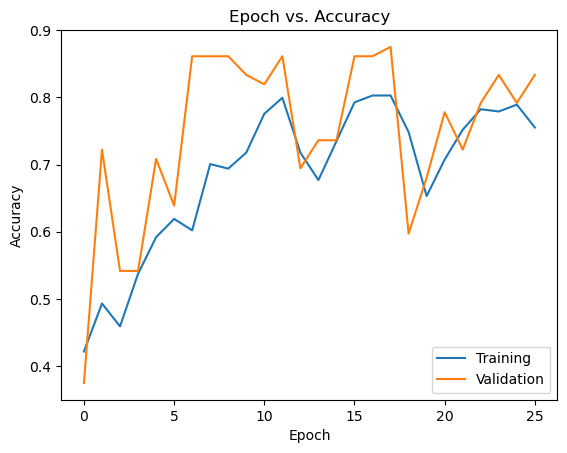

In [29]:
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Epoch vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

And second, we plot the number of epochs against the loss.

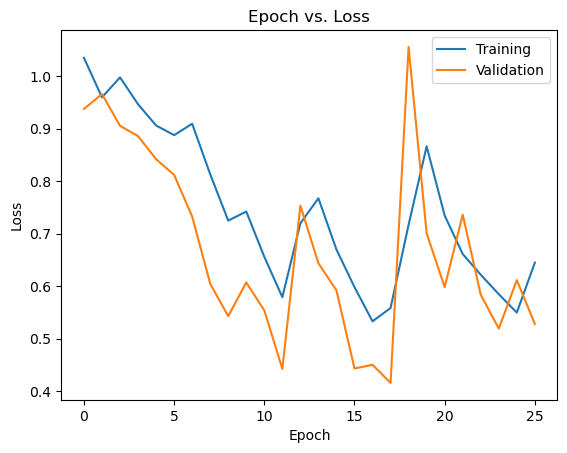

In [30]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Epoch vs. Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

Although the curves for the training data looks ok, the curves for the validation has quite some jumps. That is probably because of the low number of images in the dataset, and therefore a poor generalization of the model.

## Perform predictions

In the following, we perform some predictions for the test data. Remember that the data generator returns batches of data as pairs of images and labels. So, we get the first batch (with the `[]` operator, unpack the returned pair into images and labels, and take from the batch one image and one label at some specified index (`idx`). Then we plot the image. (You can change the idx variable if you want some other input image.)

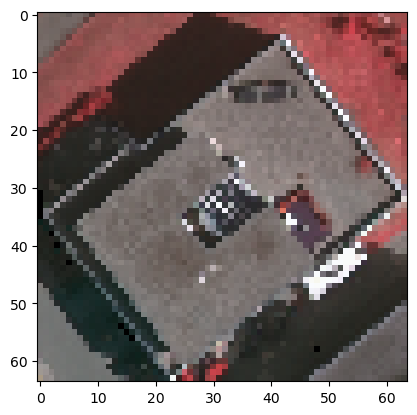

In [66]:
from keras.preprocessing import image

test_batch = test_generator[0] #number of batches

images, labels = test_batch

idx = 10    # chose one image from the batch.

img = images[idx] 
lab = labels[idx]

_ = plt.imshow(img)

Let us do the predictions on the whole batch, and print the class probabilities on the chosen image.

In [67]:
class_prob = model_5.predict(images)

print(class_prob[idx])

1/1 [==============================] - 0s 23ms/step
[0.8546594  0.13168415 0.01365647]


But remember that class_prob is a tensor that gives the class probabilitis for the whole batch.

In [68]:
print(class_prob[0])
class_prob.shape

[0.77094465 0.1687521  0.06030322]


(32, 3)

Get the indices of the predicted classes for the whole batch, and output the predicted classes (as indices).

In [69]:
class_indices = np.argmax(class_prob[0], axis=-1)
class_indices

0

In [70]:
class_indices = np.argmax(class_prob, axis=-1)
class_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

**Question 4: Do you notice anything strange with these predictions? Why is this?**

For comparison reasons, also get the class indices for the true labels.

In [71]:
len(labels)  # due to the batch size.

32

In [72]:
actual_labels=np.argmax(labels, axis=-1)

To make more sense of the class indices, we can use the `class_indices` attribute of the generators, which is a dictionary that maps the folder names to the class values that were assigned by the data generator object. With the `items()` method of a dictionary, all items stored in it can be retrieved.

In [73]:
train_generator.class_indices.items()

dict_items([('flat_roof', 0), ('hip_roof', 1), ('other_roof', 2)])

In [74]:
#Comparing the predicted to to testing data.
correct_predictions = 0

# Loop through each predicted and actual label pair
for pred, actual in zip(class_indices, actual_labels):
    # Check if the predicted label matches the actual label
    if pred == actual:
        correct_predictions += 1
    # Print the predicted and actual labels
   # print(f'y_pred: {pred}, y_test: {actual}')

# Calculate accuracy
accuracy = correct_predictions / len(actual_labels) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 90.62%


Unfortunately, there is no convenient way to search a dictionary by its containing values, and then get from the found value the key. (Using a dictionary, we typically have the key and want the value, and not the other way round.) Therefore, we have to create a second dictionary for getting from the class_index to the class name.

In [75]:
index_to_class_name = {} # init empty dictionary
for key, value in train_generator.class_indices.items():
    index_to_class_name[value] = key # add reverse entry
print("reverse dictionary",index_to_class_name)

for predicted_cls in class_indices:
    print(index_to_class_name[predicted_cls])          

reverse dictionary {0: 'flat_roof', 1: 'hip_roof', 2: 'other_roof'}
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
hip_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
hip_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
flat_roof
hip_roof
flat_roof
flat_roof


This concludes this notebook. In the following are the answers to the above questions.

## Answers to questions:

**Question 1: What happened during training and what is your neural network doing when performing predictions (both for validation and test data)?**
- The network was unable to learn anything meaningful, and it just predicts the same class that is most represented (hip roof) to get the highest accuracy. That is why the accuracy is the same as the percentage of hip roofs in the validation data (during fit), and in the test data (as the result of the evaluation). It is unlikely that the model is overfitted, because the accuracy of the training data is also quite low. 

**Question 2: Why is the loss improving (or changing) although the accuracy stays the same?**
- The values of the class probabilities do still change, and therefore the loss values. But the network still predicts the same class for each input.

**Question 3: Where are most of the parameters (weights) used in the fully connected network, and where are most of the parameters in the convolutional neural network? Why is this the case?**
- In the fully connected network, most parameters are used in the first dense layer, because each neuron takes all the input values and multiplies a weight with each input value. We therefore have as many weights as the number of input values times the number of neurons (ignoring the biases). And the number of inputs for the flattened images are rather high. In the following layers, the number of inputs is much smaller (and dependent on the number of neurons of the previous layer.) In the convolutional neural network, however, most of the weights are in the second part of the network, in the classifier. But again in the dense layer. Here, the dense layer takes as input the flattened tensor of extracted features, which has even more values than the (flattened) input image (used in the fully connected network). And you probably also used more neurons in this layer than in the first layer of the fully connected network. Therefore, the number of parameters in this layer is very high, which results in the large number of parameters for the whole network.

**Question 4: Do you notice anything strange with these predictions? Why is this?**
- There are no predictions for class 2. You could check the other batches too, if you find any predictions for class 2. But there probably is none. The reason is very likely that class 2 is so underrepresented that the network did not learn on how to predict it at all. By learning to predict images of class 2, it probably makes more errors on the other classes, so that in the end it is not worth it. Also, the dataset is very small, so increasing the number samples would definitely help.